In [11]:
import pandas as pd
import numpy as np

# --- Load datasets ---
daily = pd.read_csv("daily_stats.csv")
weather_station = pd.read_csv("USW00023272.csv", low_memory=False)
weather = pd.read_csv("weather_2018_2024.csv")

# --- Clean weather_station data ---
weather_station = weather_station[["DATE", "PRCP", "TMAX", "TMIN"]].copy()
weather_station["DATE"] = pd.to_datetime(weather_station["DATE"])

for col in ["PRCP", "TMAX", "TMIN"]:
    weather_station[col] = (
        weather_station[col]
        .astype(str)
        .str.strip()
        .replace({"M": np.nan, "": np.nan, "T": "0.0"})
    )
    weather_station[col] = pd.to_numeric(weather_station[col], errors="coerce")

# Convert from tenths of °C/mm to normal units
weather_station["TMAX"] = weather_station["TMAX"] / 10
weather_station["TMIN"] = weather_station["TMIN"] / 10
weather_station["PRCP"] = weather_station["PRCP"] / 10
weather_station["TAVG"] = (weather_station["TMAX"] + weather_station["TMIN"]) / 2

# --- Clean daily rentals data ---
daily["date"] = pd.to_datetime(daily["date"])

# --- Clean weather_2018_2024 data ---
weather["DATE"] = pd.to_datetime(weather["DATE"], errors="coerce")

# --- Quick checks ---
print("Daily stats sample:")
print(daily.head(), "\n")
print("Weather station sample:")
print(weather_station.head(), "\n")
print("Weather 2018–2024 sample:")
print(weather.head())

Daily stats sample:
        date  avg_duration_sec  pct_bike_share_yes  pct_subscriber  \
0 2018-01-01       1870.569455            9.818182       57.818182   
1 2018-01-02        979.447417            5.965560       88.407134   
2 2018-01-03        739.360168            4.865243       91.774589   
3 2018-01-04        730.779091            5.000000       91.606061   
4 2018-01-05        756.418605            5.953488       88.930233   

   total_trips  
0         1375  
1         3252  
2         2857  
3         3300  
4         2150   

Weather station sample:
        DATE  PRCP  TMAX  TMIN   TAVG
0 1921-01-01   0.0  15.6   7.2  11.40
1 1921-01-02   0.0  12.2   7.8  10.00
2 1921-01-03   0.0  15.6  10.0  12.80
3 1921-01-04   0.0  16.1   8.3  12.20
4 1921-01-05   9.7  12.2   8.3  10.25 

Weather 2018–2024 sample:
       STATION       DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00023272 2018-01-01   37.7705  -122.4269       45.7   
1  USW00023272 2018-01-02   37.7705  -122.4269       

Merged data sample:
        date  avg_duration_sec  pct_bike_share_yes  pct_subscriber  \
0 2018-01-01       1870.569455            9.818182       57.818182   
1 2018-01-02        979.447417            5.965560       88.407134   
2 2018-01-03        739.360168            4.865243       91.774589   
3 2018-01-04        730.779091            5.000000       91.606061   
4 2018-01-05        756.418605            5.953488       88.930233   

   total_trips       DATE  PRCP  TMAX  TMIN   TAVG  
0         1375 2018-01-01   0.0  16.1   8.9  12.50  
1         3252 2018-01-02   0.0  16.1  11.1  13.60  
2         2857 2018-01-03   2.3  14.4  11.7  13.05  
3         3300 2018-01-04   1.5  17.2  11.7  14.45  
4         2150 2018-01-05   6.6  16.1  11.1  13.60  

Merged shape: (2528, 10)

Correlation matrix:
             total_trips      TMAX      TMIN      TAVG      PRCP
total_trips     1.000000  0.352185  0.298489  0.355778 -0.275388
TMAX            0.352185  1.000000  0.715201  0.957751 -0.198440

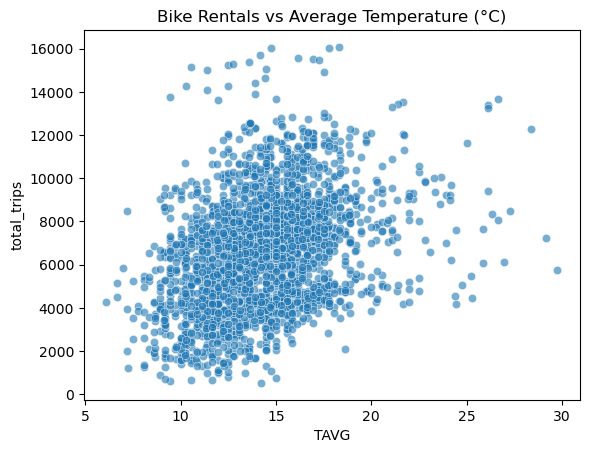

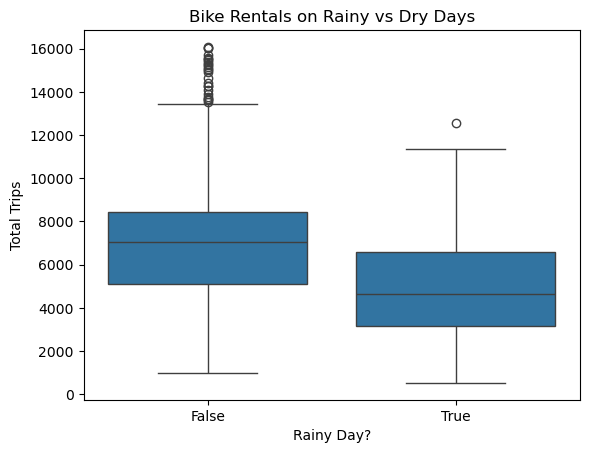

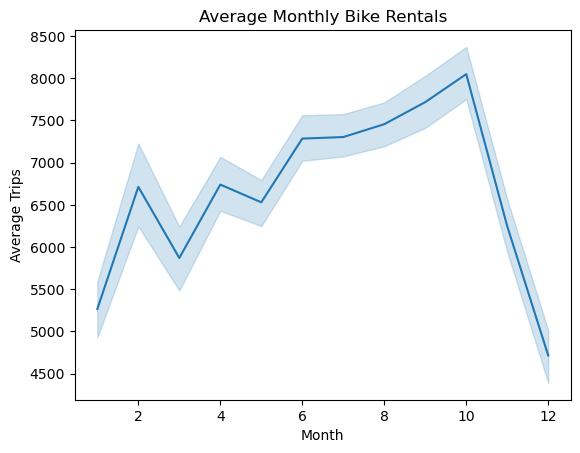

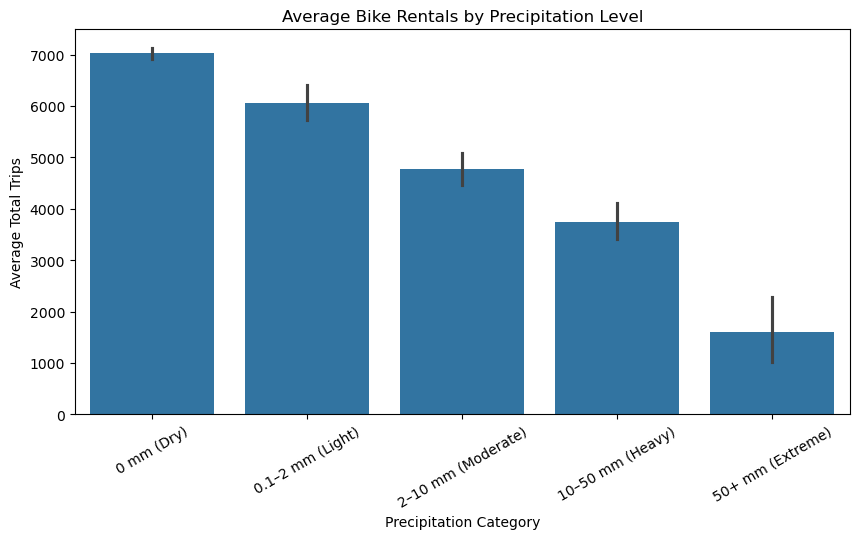

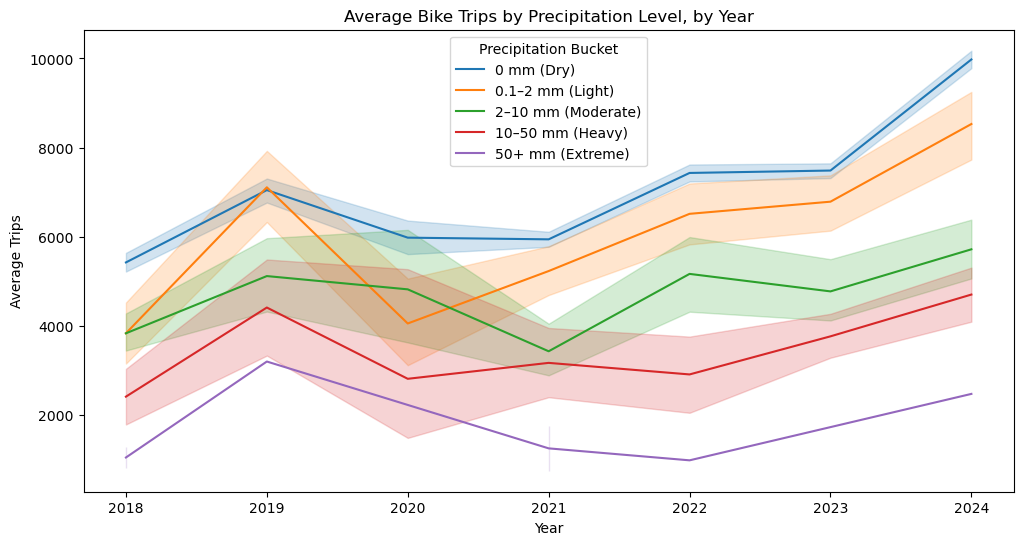

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge bike rentals with cleaned weather data
merged = pd.merge(
    daily,
    weather_station,
    left_on="date",
    right_on="DATE",
    how="inner"
)

print("Merged data sample:")
print(merged.head())
print("\nMerged shape:", merged.shape)

# Quick correlation check between weather and rentals
corr_vars = ["total_trips", "TMAX", "TMIN", "TAVG", "PRCP"]
print("\nCorrelation matrix:")
print(merged[corr_vars].corr())

# Visualization Temperature vs Rentals
sns.scatterplot(data=merged, x="TAVG", y="total_trips", alpha=0.6)
plt.title("Bike Rentals vs Average Temperature (°C)")
plt.show()

# Visualization Rain vs Rentals
merged["Rainy"] = merged["PRCP"] > 0
sns.boxplot(data=merged, x="Rainy", y="total_trips")
plt.title("Bike Rentals on Rainy vs Dry Days")
plt.xlabel("Rainy Day?")
plt.ylabel("Total Trips")
plt.show()

# Visualization monthly trends
merged["month"] = merged["date"].dt.month
sns.lineplot(data=merged, x="month", y="total_trips", estimator="mean")
plt.title("Average Monthly Bike Rentals")
plt.xlabel("Month")
plt.ylabel("Average Trips")
plt.show()

# Visualization Rentals by Precipitation Level
bins = [0, 0.1, 2, 10, 50, merged["PRCP"].max()]
labels = ["0 mm (Dry)", "0.1–2 mm (Light)", "2–10 mm (Moderate)", 
          "10–50 mm (Heavy)", "50+ mm (Extreme)"]

merged["prcp_bucket"] = pd.cut(merged["PRCP"], bins=bins, labels=labels, include_lowest=True)


merged["year"] = merged["date"].dt.year

plt.figure(figsize=(10,5))
sns.barplot(data=merged, x="prcp_bucket", y="total_trips", estimator="mean")
plt.title("Average Bike Rentals by Precipitation Level")
plt.xlabel("Precipitation Category")
plt.ylabel("Average Total Trips")
plt.xticks(rotation=30)
plt.show()

# Visualization Rentals by Year and Precipitation Level 2018-2024
plt.figure(figsize=(12,6))
sns.lineplot(
    data=merged,
    x="year",
    y="total_trips",
    hue="prcp_bucket",
    estimator="mean"
)
plt.title("Average Bike Trips by Precipitation Level, by Year")
plt.xlabel("Year")
plt.ylabel("Average Trips")
plt.legend(title="Precipitation Bucket")
plt.show()



# ----------------------------------------------------

### **Correlation Matrix Analysis:**


The correlation matrix indicates that temperature has a moderate positive correlation with daily bike rentals (r ≈ 0.35). This means warmer days generally encourage more biking activity. Precipitation shows a negative correlation (r ≈ -0.27), confirming that rainfall suppresses demand. These correlations are statistically meaningful, though not perfect, implying that other behavioral and temporal factors also influence usage.

### **Bike Rentals vs. Average Temperature Analysis:**

The scatterplot reveals a clear upward trend: as average temperature increases, total bike rentals also rise.
Most data points cluster between 10–17 °C, reflecting San Francisco’s mild maritime climate.
Even within this narrow temperature band, warmer days correspond with noticeably higher ridership. This suggests that modest temperature shifts within SF’s stable climate still have tangible effects on biking behavior.

### **Bike Rentals on Rainy vs. Dry Days Analysis:**

The boxplot shows a pronounced difference between rainy and dry days.
Median ridership drops significantly on rainy days, roughly 1,500 fewer trips per day, according to the regression results.
This confirms that rain has an immediate and strong dampening effect on biking, likely due to safety and comfort concerns.

### **Average Monthly Bike Rentals Analysis:**

The monthly trend line captures a clear seasonal pattern.
Ridership rises through the spring and summer, peaking in September-October, before falling sharply in winter.
This seasonal cycle mirrors weather conditions and daylight availability, but it also aligns with commuting and recreational habits tied to the academic and work year.

### **Average Bike Rentals by Precipitation Level Analysis:**

The precipitation levels show a clear descending pattern in bike rentals. As precipitation levels increase in mm, bike rentals decrease as expected. This can be caused by the increased level of danger of biking as the ground gets increasingly wet. 


### **Average Bike Trips by Year:**

This chart shows that bike usage is consistently highest on dry days, with trips steadily increasing from 2018 to 2024. I was curious to see if there was an increase during 2021 with the peak of COVID and people trying to do outdoor activities, but it actually led to a decrease of bike rentals.

# ----------------------------------------------------

In [13]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1) Build a clean regression frame
reg = merged[["total_trips", "TAVG", "PRCP", "date"]].copy()

reg = reg.replace([np.inf, -np.inf], np.nan).dropna(subset=["total_trips", "TAVG", "PRCP"])

# 2) Simple OLS with robust SEs
X = sm.add_constant(reg[["TAVG", "PRCP"]])
y = reg["total_trips"]
model = sm.OLS(y, X).fit(cov_type="HC1")
print(model.summary())

# 3) Add day-of-week controls and a rainy-day flag
reg["dow"]  = reg["date"].dt.dayofweek              # 0=Mon ... 6=Sun
reg["rain"] = (reg["PRCP"] > 0).astype(int)

model_dow = smf.ols("total_trips ~ TAVG + PRCP + C(dow)", data=reg).fit(cov_type="HC1")
print("\n=== With day-of-week controls ===")
print(model_dow.summary().tables[1])

model_rain = smf.ols("total_trips ~ TAVG + rain + C(dow)", data=reg).fit(cov_type="HC1")
print("\n=== Using rainy-day indicator instead of PRCP (mm) ===")
print(model_rain.summary().tables[1])

                            OLS Regression Results                            
Dep. Variable:            total_trips   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     203.6
Date:                Sat, 13 Dec 2025   Prob (F-statistic):           1.21e-82
Time:                        22:02:58   Log-Likelihood:                -23024.
No. Observations:                2507   AIC:                         4.605e+04
Df Residuals:                    2504   BIC:                         4.607e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2831.2290    255.464     11.083      0.0

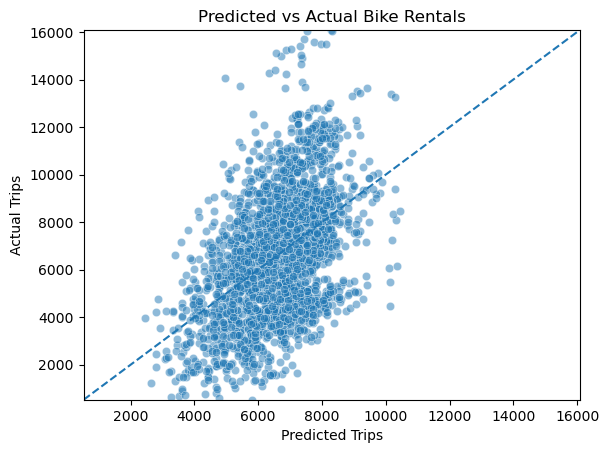

In [14]:
# Predictions using the rainy-day model on the same cleaned frame
reg["predicted"] = model_rain.predict(reg)

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=reg, x="predicted", y="total_trips", alpha=0.5)
plt.xlabel("Predicted Trips")
plt.ylabel("Actual Trips")
plt.title("Predicted vs Actual Bike Rentals")

# 45-degree line
lims = [min(reg["predicted"].min(), reg["total_trips"].min()),
        max(reg["predicted"].max(), reg["total_trips"].max())]
plt.plot(lims, lims, linestyle="--")
plt.xlim(lims); plt.ylim(lims)
plt.show()

# ----------------------------------------------------

### **Regression Model Insights:**

Regression analysis quantifies these visual trends:

- Each additional 1 °C increase in temperature --> ≈ 250 more rentals per day.

- Each additional 1 mm of rain --> ≈ 90 fewer rentals per day.

- On rainy days, rentals drop by an average of ~1,500 trips.

- After controlling for day-of-week, temperature and rain remain statistically significant, while weekdays (Tue–Thu) see more trips than weekends.

### **Model Validation:**

The “Predicted vs Actual” scatterplot shows predictions closely aligned with real observations along the 45° line.
While there is natural spread (R² ≈ 0.17), the model successfully captures the general pattern: warmer, dry weekdays drive higher ridership.

### **Overall Conclusion:**

San Francisco’s narrow but consistent temperature range still meaningfully influences daily bike rentals. Warmer and dry days encourage more rides, while rain sharply decreases demand. Temporal factors like weekday and season amplify these effects, demonstrating how even mild weather variability shapes urban mobility behavior.

# ----------------------------------------------------